- Code taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import pandas as pd

cudnn.benchmark = True
plt.ion() 

C:\Miniconda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.getcwd()

'f:\\NLP-Proj\\Notebooks'

In [3]:
data = pd.read_csv("../Dataset/matchedpairs_finalds.csv")
data = data.sample(frac=1).reset_index(drop = True)
total_labels = data.OriginalEntity.unique()
#np.save("../Dataset/img_classification_labels.npy", total_labels)

data.loc[:, "Labels"] = data.OriginalEntity.apply(lambda x: np.where(x == total_labels)[0][0])

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)
train.to_csv("../Dataset/train.csv", index = False)
test.to_csv("../Dataset/val.csv", index = False)


In [4]:
class ImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_path,mode,root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.entityds = pd.read_csv(data_path)
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.entityds)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.entityds.loc[idx, "Image"])
        image = cv2.imread(img_name)
        if self.transform:
            image = self.transform(image)
        
        labels = -1
        if self.mode != 'test':
            labels = self.entityds.loc[idx, "Labels"]
        #sample = {'image': image, 'entity': labels}

        return image, labels

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
}

data_dir = '../Dataset/matchedpairs_finalds.csv'
image_datasets = {x: ImageDataset(data_path=f"../Dataset/{x}.csv",
                                    mode=x,
                                    root_dir='../Dataset/images/'
                                    ,transform= data_transforms[x])
                                    for x in ['train', 'val', 'test']}
                                    
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = total_labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Get the mean band variance of entire dataset
print(image_datasets["train"][0][0].shape,dataset_sizes)
'''
total_samples = len(image_datasets["train"])
mean = 0
var = 0
for i in range(total_samples):
    sample = image_datasets["train"][i]
    mean += torch.mean(sample["image"], dim = [1,2])
mean = mean / total_samples
print(mean)

for i in range(total_samples):
    image = image_datasets["train"][i]["image"]
    image = image.view(image.size(0),-1)
    var += ((image - mean.unsqueeze(1))**2).sum([1])
var = torch.sqrt(var / (total_samples*224*224))
print(var)
'''

torch.Size([3, 224, 224]) {'train': 1027, 'val': 257, 'test': 2}


'\ntotal_samples = len(image_datasets["train"])\nmean = 0\nvar = 0\nfor i in range(total_samples):\n    sample = image_datasets["train"][i]\n    mean += torch.mean(sample["image"], dim = [1,2])\nmean = mean / total_samples\nprint(mean)\n\nfor i in range(total_samples):\n    image = image_datasets["train"][i]["image"]\n    image = image.view(image.size(0),-1)\n    var += ((image - mean.unsqueeze(1))**2).sum([1])\nvar = torch.sqrt(var / (total_samples*224*224))\nprint(var)\n'

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': best_model_wts,
                            'class_names': class_names,
                            'loss': loss,
                            }, "../Models/img_class.pt")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def visualize_model(model, mode='val', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[mode]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
#for param in model_ft.parameters():
#    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(total_labels))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/24
----------
train Loss: 2.6851 Acc: 0.2639
val Loss: 2.2123 Acc: 0.4903

Epoch 1/24
----------
train Loss: 1.3995 Acc: 0.8004
val Loss: 1.5443 Acc: 0.7082

Epoch 2/24
----------
train Loss: 0.8522 Acc: 0.8744
val Loss: 1.2385 Acc: 0.7198

Epoch 3/24
----------
train Loss: 0.5954 Acc: 0.8909
val Loss: 1.0534 Acc: 0.7860

Epoch 4/24
----------
train Loss: 0.4590 Acc: 0.9309
val Loss: 0.9697 Acc: 0.7899

Epoch 5/24
----------
train Loss: 0.3683 Acc: 0.9357
val Loss: 0.9149 Acc: 0.7977

Epoch 6/24
----------
train Loss: 0.3081 Acc: 0.9591
val Loss: 0.8495 Acc: 0.8171

Epoch 7/24
----------
train Loss: 0.2437 Acc: 0.9698
val Loss: 0.8412 Acc: 0.8093

Epoch 8/24
----------
train Loss: 0.2370 Acc: 0.9698
val Loss: 0.8264 Acc: 0.7899

Epoch 9/24
----------
train Loss: 0.2332 Acc: 0.9737
val Loss: 0.8170 Acc: 0.8093

Epoch 10/24
----------
train Loss: 0.2185 Acc: 0.9786
val Loss: 0.8396 Acc: 0.7860

Epoch 11/24
----------
train Loss: 0.2159 Acc: 0.9747
val Loss: 0.8344 Acc: 0.7860

Ep

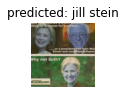

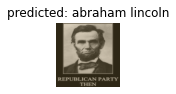

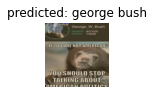

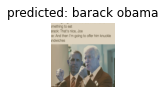

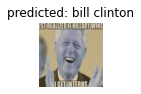

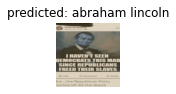

In [11]:
visualize_model(model_ft)